# Finding Cycles in NFT Transactions

## Overview

A Non-fungible Token (NFT) is a digital asset which cannot be copied, substituted, or subdivided, meaning it is wholly unique.

NFT’s are stored on blockchain systems, notably Ethereum, with the owner of an NFT being whomever has access to the wallet it is stored within.

Since the first NFT, Quantum, many new NFT artworks have arisen including Cryptokitties and Cryptopunks. This culminated in a boom in 2021 which included the arrival of the Bored Ape Yacht Club, with NFTS reaching a global market valued of $15.7 Billion.

In this example we will analyse an NFT dataset in order to find suspicious trading cycles.

1. Using Raphtory to load the NFT data as a graph
2. Execute a cycle detection algorithm
3. Analyse the results

## Loading data with Raphtory

Our imports

In [ ]:
pip install scipy seaborn

In [4]:
import time
from calendar import timegm
from pyraphtory.context import PyRaphtory
from pyraphtory.builder import *
from pyraphtory.spouts import FileSpout
from pyraphtory.sinks import FileSink
from pyraphtory.formats import JsonFormat
import csv

Our data sources

In [ ]:
eth_price_csv = '/Users/haaroony/Documents/nft/ETH-USD.csv'
filename = "/Users/haaroony/OneDrive - Pometry Ltd/nft_andrea/sample/Data_API_250k.csv"
at_time = 1619560520

Helper functions

In [ ]:
def setup_date_prices(eth_historic_csv="/tmp/ETH-USD.csv"):
    date_price_map = {}
    with open(eth_historic_csv) as csvfile:
        reader = csv.DictReader(csvfile, delimiter=',')
        for row in reader:
            date_price_map[row['Date']] = (float(row['High']) + float(row['Low'])) / 2
    return date_price_map

date_price = setup_date_prices(eth_price_csv)

The code we use to load our the data into a graph

In [ ]:
def parse_graph(graph, line):
    file_line = line.split(',')
    if file_line[0] == "Smart_contract":
        return
    # Seller details
    seller_address = file_line[3]
    seller_address_hash = graph.assign_id(seller_address)
    # Buyer details
    buyer_address = file_line[5]
    buyer_address_hash = graph.assign_id(buyer_address)
    # Transaction details
    datetime_str = file_line[13]
    timestamp_utc = time.strptime(datetime_str, "%Y-%m-%d %H:%M:%S")
    timestamp = timegm(timestamp_utc)
    tx_hash = file_line[2]
    token_id_str = file_line[1]
    token_id_hash = graph.assign_id(token_id_str)

    crypto = file_line[8]
    if crypto != 'ETH':
        return

    if file_line[9] == "":
        price_usd = date_price[datetime_str[0:10]]
    else:
        price_usd = float(file_line[9])

    # NFT Details
    collection_cleaned = file_line[14]
    market = file_line[11]
    category = file_line[15]

    #  add buyer node
    graph.add_vertex(
        timestamp,
        buyer_address_hash,
        Properties(ImmutableProperty("address", buyer_address)),
        Type("Wallet")
    )

    # add seller node
    graph.add_vertex(
        timestamp,
        seller_address_hash,
        Properties(ImmutableProperty("address", seller_address)),
        Type("Wallet")
    )

    # Add node for NFT
    graph.add_vertex(
        timestamp,
        token_id_hash,
        Properties(
            ImmutableProperty("id", token_id_str),
            ImmutableProperty("collection", collection_cleaned),
            ImmutableProperty("category", category)
        ),
        Type("NFT")
    )

    # Creating a bipartite graph,
    # add edge between buyer and nft
    graph.add_edge(
        timestamp,
        buyer_address_hash,
        token_id_hash,
        Properties(
            StringProperty("transaction_hash", tx_hash),
            StringProperty("crypto", crypto),
            StringProperty("price_usd", str(price_usd)),
            StringProperty("market", market),
            StringProperty("token_id", token_id_str),
            StringProperty("buyer_address", buyer_address)
        ),
        Type("Purchase")
    )

Now we will start a raphtory instance and load our data

In [ ]:
pr = PyRaphtory(logging=True).open()
graph = pr.new_graph()

graph.load(Source(FileSpout(filename), GraphBuilder(parse_graph)))

## Executing a Cycle detection algorithm

In [ ]:
from pyraphtory.algorithm import PyAlgorithm
from pyraphtory.graph import TemporalGraph, Row
from pyraphtory.vertex import Vertex

CYCLES_FOUND: str = "CYCLES_FOUND"

class CycleMania(PyAlgorithm):
def __call__(self, graph: TemporalGraph) -> TemporalGraph:
    def step(v: Vertex):
        if v.type() != "NFT":
            v[CYCLES_FOUND] = []
            return
        all_cycles = []
        all_purchases = sorted(v.explode_in_edges(), key=lambda e: e.timestamp())
        purchasers = list(map(lambda e:
                              dict(buyer=e.get_property_or_else("buyer_address", "_UNKNOWN_"),
                                   price_usd=float(e.get_property_or_else("price_usd", 0.0)),
                                   time=e.timestamp(),
                                   tx_hash=e.get_property_or_else("transaction_hash", ""),
                                   nft_id=e.get_property_or_else("token_id", "_UNKNOWN_")),
                              all_purchases))
        if len(purchasers) > 2:
            buyers_seen = {}
            for pos, item_sale in enumerate(purchasers):
                buyer_id = item_sale['buyer']
                if buyer_id not in buyers_seen:
                    buyers_seen[buyer_id] = pos
                else:
                    prev_pos = buyers_seen[buyer_id]
                    prev_price = purchasers[prev_pos]['price_usd']
                    current_price = item_sale['price_usd']
                    buyers_seen[buyer_id] = pos
                    if prev_price < current_price:
                        all_cycles.append(purchasers[prev_pos:pos + 1])
        if len(all_cycles):
            v[CYCLES_FOUND] = all_cycles
        else:
            v[CYCLES_FOUND] = []

    return graph.reduced_view().step(step)

def tabularise(self, graph: TemporalGraph):
    def get_cycles(v: Vertex):
        vertex_type = v.type()
        rows_found = [Row()]
        if vertex_type == "NFT" and len(v[CYCLES_FOUND]):
            nft_id = str(v.id())
            cycles_found = v[CYCLES_FOUND]
            nft_collection = v.get_property_or_else('collection', '_UNKNOWN_')
            nft_category = v.get_property_or_else('category', '_UNKNOWN_')
            rows_found = list(map(lambda single_cycle:
                                  Row(
                                      nft_id,
                                      nft_collection,
                                      nft_category,
                                      len(single_cycle),
                                      dict(buyer=str(single_cycle[0]['buyer']),
                                           profit_usd=float(single_cycle[len(single_cycle) - 1]['price_usd']) -
                                                      float(single_cycle[0]['price_usd']),
                                           cycle=single_cycle)
                                  ), cycles_found))
        return rows_found

    return graph.explode_select(lambda v: get_cycles(v)).filter(lambda row: len(row.get_values()) > 0)

Executing the cycle detection algorithm

In [ ]:
graph
    .at(at_time)
    .past()
    .execute(CycleMania())
    .write_to(FileSink('/tmp/raphtory_nft_python', format=JsonFormat()))
    .wait_for_job()

## Analysing the results

In [10]:
import pandas as pd
import json
import seaborn as sns
from scipy import stats
import numpy as np
import time
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '16'

In [11]:
def load_json(filename):
    data = []
    with open(filename, 'r') as f:
        for r in f.readlines():
            r_json = json.loads(r)
            if r_json['row'][4]['buyer']=='0x0000000000000000000000000000000000000000':
                continue
            else:
                data.append(r_json)
    print("amount of data %i"  % len(data))
    return data

In [12]:
# For making CDFs and CCDFs
def cdf(listlike, normalised=True):
    data = np.array(listlike)
    N = len(listlike)

    x = np.sort(data)
    if (normalised):
        y = np.arange(N)/float(N-1)
    else:
        y = np.arange(N)
    return x, y

def ccdf(listlike, normalised=True):
    x, y = cdf(listlike,normalised)
    if normalised:
        return x, 1.0-y
    else:
        return x, len(listlike)-y

### Read data

In [13]:
# data = load_json('/tmp/raphtory_nft_python/CycleMania_8220652547042296969/partition-0.json')
data = load_json("/Users/haaroony/OneDrive - Pometry Ltd/nft_andrea/results/cycle_results_eth_erc721_1155.json")
data_df = pd.DataFrame(data)

amount of data 16673


In [15]:
data_df["profit"]=data_df["row"].apply(lambda x: x[4]['profit_usd'])

In [16]:
data_df["min_ts"] = data_df["row"].apply(lambda x: min(map(lambda y: y["time"],x[4]['cycle']['sales'])))

In [17]:
data_df["max_ts"] = data_df["row"].apply(lambda x: max(map(lambda y: y["time"],x[4]['cycle']['sales'])))

In [18]:
data_df["length"] = data_df["row"].apply(lambda x: len(x[4]['cycle']['sales']))

In [19]:
data_df["duration_days"] = (data_df["max_ts"] - data_df["min_ts"])/86400

In [20]:
display(data_df)

,timestamp,window,row,profit,min_ts,max_ts,length,duration_days
0,1619562578,None,"[60259_Rari, Rari, Art, 2, {'buyer': '0xfc233a...",3747.449500,1609577631,1610247255,2,7.750278
1,1619562578,None,"[60259_Rari, Rari, Art, 2, {'buyer': '0xfc233a...",18.099500,1608425450,1609033299,2,7.035289
2,1619562578,None,"[60259_Rari, Rari, Art, 2, {'buyer': '0xfc233a...",828.065000,1607718374,1608425450,2,8.183750
3,1619562578,None,[557720982044760014422846897256062512766055887...,28.137960,1614352229,1617500507,3,36.438403
4,1619562578,None,"[633479_Cryptokittie, Cryptokittie, Art, 4, {'...",3.522571,1521531679,1521614131,4,0.954306
...,...,...,...,...,...,...,...,...
16668,1619562578,None,"[72491_Rari, Rari, Art, 5, {'buyer': '0x3c1ce6...",69.890400,1604682716,1604682888,5,0.001991
16669,1619562578,None,"[569997_Cryptokittie, Cryptokittie, Art, 2, {'...",0.000229,1520013937,1521092896,2,12.487951
16670,1619562578,None,"[26111_Rari, Rari, Art, 3, {'buyer': '0x830f79...",1.914630,1604605155,1604653389,3,0.558264
16671,1619562578,None,"[11108_Rari, Rari, Art, 8, {'buyer': '0x4c8e27...",196.705605,1600302704,1602109731,8,20.914664


## Cycle length distributions

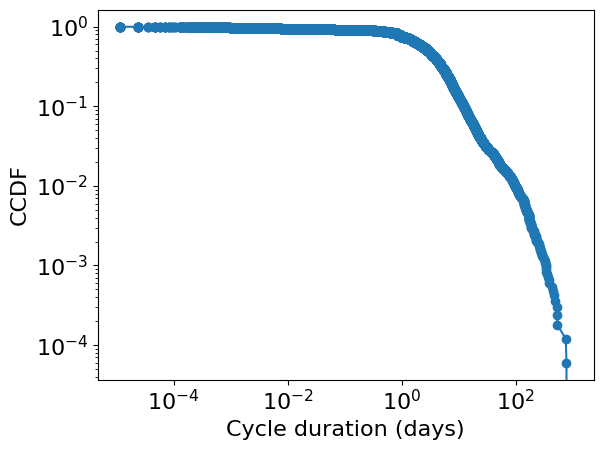

In [21]:
x,y = ccdf(data_df.duration_days)

fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(x,y, marker="o")
ax.set_ylabel("CCDF")
ax.set_xlabel("Cycle duration (days)")

plt.show()

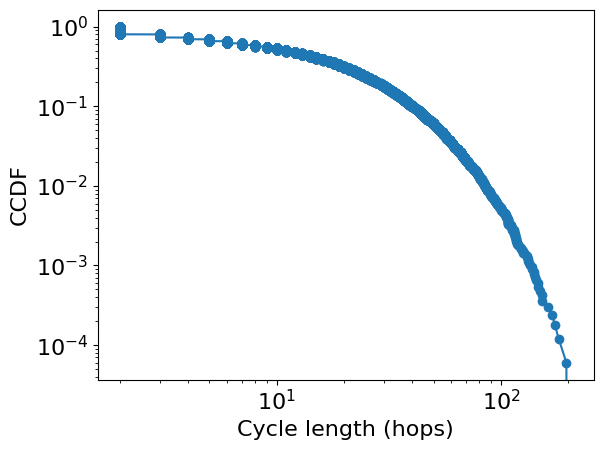

In [22]:
x,y = ccdf(data_df.length)

fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(x,y, marker="o")
ax.set_ylabel("CCDF")
ax.set_xlabel("Cycle length (hops)")

plt.show()

[7.56712963e-03 9.91689815e-01 2.91678241e+00 6.11468750e+00
 2.00502199e+01]


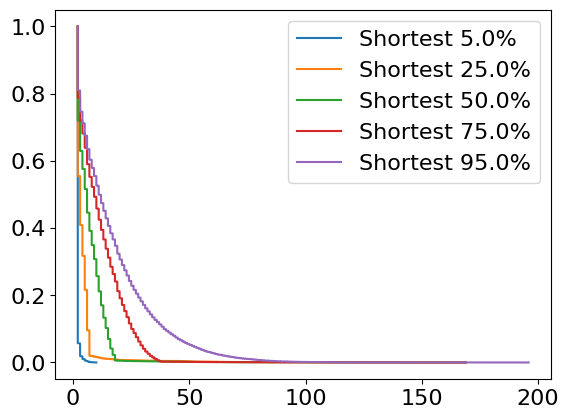

In [23]:
quantiles_of_interest = [0.05,0.25,0.50,0.75,0.95]
duration_quantiles = np.quantile(data_df.duration_days, q=quantiles_of_interest)
print(duration_quantiles)

fig, ax = plt.subplots()

for i,q in enumerate(duration_quantiles):
    x,y = ccdf(data_df[data_df.duration_days<q].length)
    ax.plot(x,y,label="Shortest "+str(quantiles_of_interest[i]*100)+"%")

ax.legend(loc="upper right")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


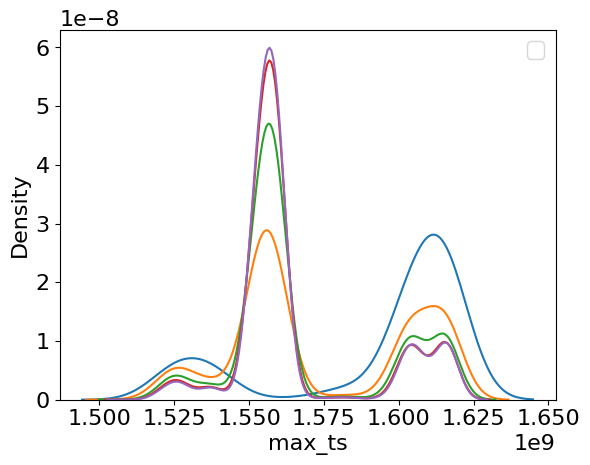

In [24]:
fig, ax = plt.subplots()
for i,q in enumerate(duration_quantiles):
    sns.kdeplot(data_df[data_df.duration_days<q].max_ts,ax=ax)

ax.legend(loc="upper right")
plt.show()

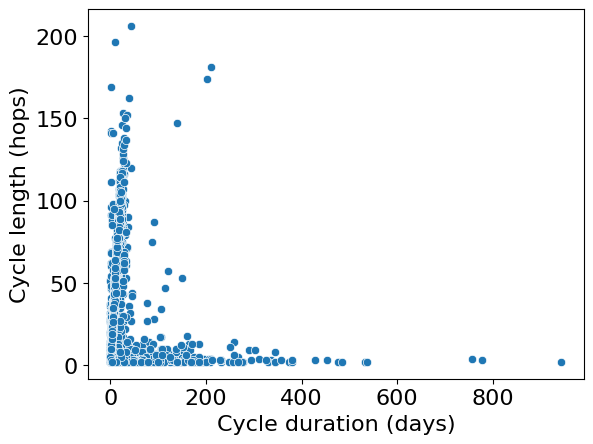

In [25]:
ax = sns.scatterplot(data=data_df, x="duration_days", y="length")
ax.set_xlabel("Cycle duration (days)")
ax.set_ylabel("Cycle length (hops)")
# ax.set_xscale("log")
# ax.set_yscale("log")
plt.show()

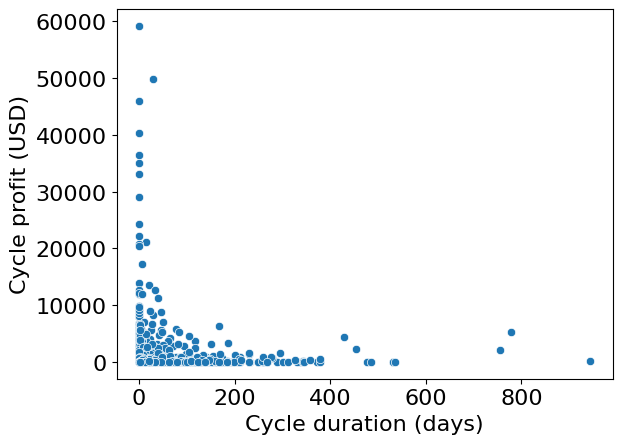

In [26]:
ax = sns.scatterplot(data=data_df, x="duration_days", y="profit")
ax.set_xlabel("Cycle duration (days)")
ax.set_ylabel("Cycle profit (USD)")
# ax.set_xscale("log")
# ax.set_yscale("log")
plt.show()

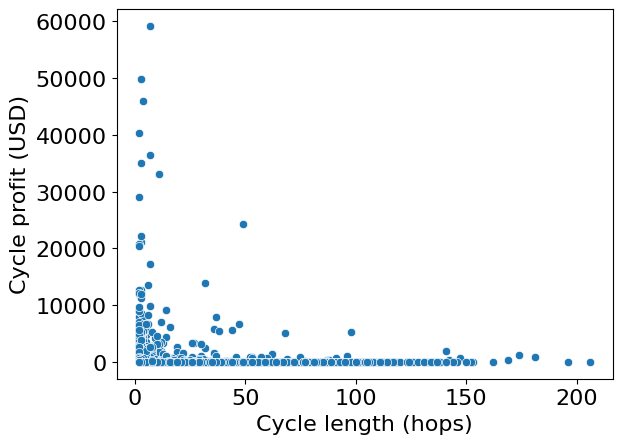

In [27]:
ax = sns.scatterplot(data=data_df, x="length", y="profit")
ax.set_xlabel("Cycle length (hops)")
ax.set_ylabel("Cycle profit (USD)")
# ax.set_xscale("log")
# ax.set_yscale("log")
plt.show()

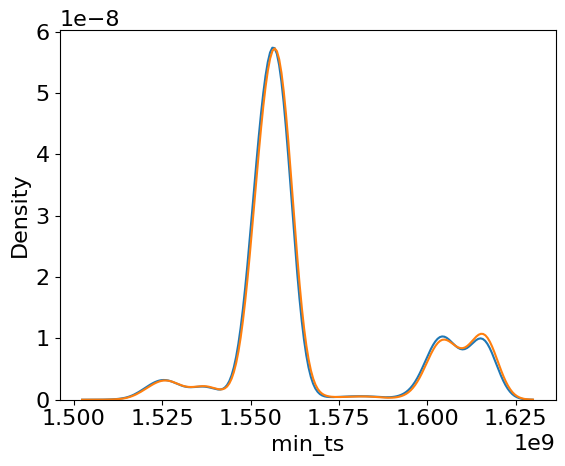

In [28]:
fig, ax = plt.subplots()
ax = sns.kdeplot(data_df.min_ts)
ax = sns.kdeplot(data_df.max_ts)

In [29]:
longest_data = max(data, key=lambda row: len(row["row"][4]['cycle']['sales']))
print("size of chain")
len(longest_data['row'][4]['cycle']['sales'])

size of chain


206

#### Most profitable NFT cycles

In [31]:
profitable_trades = np.array([x['row'][4]['profit_usd'] for x in data])

In [32]:
print("Max profit %s" % profitable_trades.max())
print("Min profit %s" % profitable_trades.min())

Max profit 59220.018
Min profit 6.697753462958644e-12


#### frequency of profits

highly skewed

In [33]:
profits = [trade['row'][4]['profit_usd'] for trade in data]

In [34]:
np.std(profits), min(profits), max(profits), len(profits)

(1141.993050903458, 6.697753462958644e-12, 59220.018, 16673)

In [35]:
np.mean(profits), stats.trim_mean(profits, 0.05), stats.trim_mean(profits, 0.10), stats.trim_mean(profits, 0.25)

(118.17145378028405, 14.269678921028847, 5.234855907639334, 2.031706742531798)

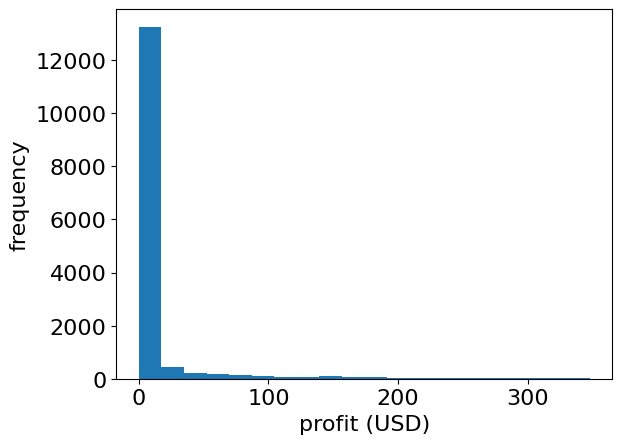

In [37]:
trimmed_profits = stats.trimboth(profits, 0.05)
plt.hist(trimmed_profits, bins=20)
plt.xlabel("profit (USD)")
plt.ylabel("frequency")
plt.savefig("/tmp/frequency_profits_trimmed.png")

#### how much of the nfts appreciated the most in the cycle

In [38]:
print("min %.4f, max %.4f, amt %i" % (min(profits), max(profits), len(profits)))
value = 80 # USD
(len([_ for _ in profits if _ <= value])/len(profits)) * 100

min 0.0000, max 59220.0180, amt 16673


90.04378336232232

# Highest Cost Cycles

Top 5 NFTs that appreciated the most

In [39]:
def pretty_cycle(cycle):
    as_string = '   '
    prev_price = cycle[0]['price_usd']
    prev_time = cycle[0]['time']
    for item in cycle:
        diff = item['price_usd']-prev_price
        time_secs = item['time']-prev_time
        time_mins = time_secs/60
        time_hours = time_secs/60/60
        time_days = time_secs/60/60/24 
        prev_time = item['time']
        time_str = '%.1fm/%.1fh/%.2fd' % (time_mins, time_hours, time_days)
        as_string += 'T(d) '+time_str+', B: '+item['buyer'][:4]+'.. $'+str(item['price_usd'])+'('+str(diff)+') '+item['tx_hash']+'\n->'
    as_string = as_string[:-3]
    print(as_string)
# pretty_cycle(all_profits_sorted[0]['cycle'])

In [40]:
profits = [trade['row'][4]['profit_usd'] for trade in data]
all_profits_sorted = []
for trade in data:
    new_trade = {
        'profit_usd': trade['row'][4]['profit_usd'],
        'buyer':  trade['row'][4]['buyer'],
        'cycle_size': trade['row'][3],
        'nft_id': trade['row'][0],
        'cycle': trade['row'][4]['cycle']['sales']
    }
    all_profits_sorted.append(new_trade)
all_profits_sorted = sorted(all_profits_sorted, key=lambda d: d['profit_usd'], reverse=True)

In [41]:
all_profits_sorted[0]

{'profit_usd': 59220.018,
 'buyer': '0x879c2ee5adc372d0542d65d80ebfe647ac1a5f10',
 'cycle_size': 7,
 'nft_id': '6929_Rari',
 'cycle': [{'buyer': '0x879c2ee5adc372d0542d65d80ebfe647ac1a5f10',
   'price_usd': 56942.325,
   'time': 1599679592,
   'tx_hash': '0x8530cee364e3aa98c5c1c4cef849dbe0780dfdb8d9a9b4674d22837028312084',
   'nft_id': '6929_Rari'},
  {'buyer': '0x896b94f4f27f12369698c302e2049cae86936bbb',
   'price_usd': 1138.8465000000006,
   'time': 1599680220,
   'tx_hash': '0xb805851908065988cb9c1747c8693e396d22432024e951b5133be7ff5ea8053a',
   'nft_id': '6929_Rari'},
  {'buyer': '0x93207b8c861cf2b96a92c41d99da0e9615f1a3ea',
   'price_usd': 4555.386000000001,
   'time': 1599681810,
   'tx_hash': '0x5cd83126cc066245a1da552c7f6f97f0537ac8d705838d1010f74432cdd8c6fd',
   'nft_id': '6929_Rari'},
  {'buyer': '0x490697b59520cfa81938df18b4634081556d3d15',
   'price_usd': 113.88465,
   'time': 1599682010,
   'tx_hash': '0xa2de576299276233ce73cc62494f93150c0efbda23ffaf9be80a5e75ba88a378',
 

In [42]:
for trade in all_profits_sorted[:5]:
    print("B: %s, PROFIT %.3f, HOPS %i" % (trade['buyer'][:5],trade['profit_usd'], trade['cycle_size']))
    pretty_cycle(trade['cycle'])
    print()

B: 0x879, PROFIT 59220.018, HOPS 7
   T(d) 0.0m/0.0h/0.00d, B: 0x87.. $56942.325(0.0) 0x8530cee364e3aa98c5c1c4cef849dbe0780dfdb8d9a9b4674d22837028312084
->T(d) 10.5m/0.2h/0.01d, B: 0x89.. $1138.8465000000006(-55803.4785) 0xb805851908065988cb9c1747c8693e396d22432024e951b5133be7ff5ea8053a
->T(d) 26.5m/0.4h/0.02d, B: 0x93.. $4555.386000000001(-52386.939) 0x5cd83126cc066245a1da552c7f6f97f0537ac8d705838d1010f74432cdd8c6fd
->T(d) 3.3m/0.1h/0.00d, B: 0x49.. $113.88465(-56828.44035) 0xa2de576299276233ce73cc62494f93150c0efbda23ffaf9be80a5e75ba88a378
->T(d) 7.2m/0.1h/0.01d, B: 0xd3.. $113.88465(-56828.44035) 0x14f8867198a82fb96bc63a4eff8dcce46d49a17ef92200b2bf89d17d2a9dfb92
->T(d) 0.0m/0.0h/0.00d, B: 0x42.. $341.65395(-56600.67105) 0x2f6ef591fb1a2da6a8a27edc56b088ab9104aa77063099cfb72d82e67125eb99
->T(d) 10.4m/0.2h/0.01d, B: 0x87.. $116162.343(59220.018) 0x6401d73024c774a98789d7745fd7e70eeb8b43f86ede0d64438409e83023e5eb

B: 0xb16, PROFIT 49936.400, HOPS 3
   T(d) 0.0m/0.0h/0.00d, B: 0xb1.. $4751

### Delete all rari token cycles

In [43]:
all_profits_sorted_no_rari = []
for trade in data:
    if '_Rari' in trade['row'][0] or trade['row'][3] <= 2:
        continue
    new_trade = {
        'profit_usd': trade['row'][4]['profit_usd'],
        'buyer':  trade['row'][4]['buyer'],
        'cycle_size': trade['row'][3],
        'nft_id': trade['row'][0],
        'cycle': trade['row'][4]['cycle']['sales']
    }
    all_profits_sorted_no_rari.append(new_trade)
all_profits_sorted_no_rari = sorted(all_profits_sorted_no_rari, key=lambda d: d['profit_usd'], reverse=True)

In [44]:
for trade in all_profits_sorted_no_rari[:5]:
    print("B: %s, PROFIT %.3f, HOPS %i" % (trade['buyer'][:5],trade['profit_usd'], trade['cycle_size']))
    pretty_cycle(trade['cycle'])
    print()

B: 0xb16, PROFIT 49936.400, HOPS 3
   T(d) 0.0m/0.0h/0.00d, B: 0xb1.. $47512.0(0.0) 0x5f070ac611b997e4a87696ce962cbfd6798eb600c941895e0488273c69aea5b9
->T(d) 32128.7m/535.5h/22.31d, B: 0x8e.. $80190.9(32678.899999999994) 0x905ed48693a03d5258546e97b4485daa44c7d789ee493d91b67e6e80e049ea0c
->T(d) 8561.3m/142.7h/5.95d, B: 0xb1.. $97448.4(49936.399999999994) 0x3c9d576d6a16b0c8705765eca1f2abdbb184e63bd815d656d6724a35786d367e

B: 0xef7, PROFIT 12606.265, HOPS 3
   T(d) 0.0m/0.0h/0.00d, B: 0xef.. $51233.07499999999(0.0) 0x3d9f15234fe1348ff17d1f8118e6405c8ae1b2c0c87e25a588e95f68c3ff498e
->T(d) 48071.5m/801.2h/33.38d, B: 0x00.. $47406.62100000001(-3826.4539999999834) 0x69f1eea5568cfd217d8e3d6c7ae601e34c9af905feb6249ac510741b62f0a3c4
->T(d) 12.9m/0.2h/0.01d, B: 0xef.. $63839.34(12606.265000000007) 0x941a42df26a585af6aafa0720ea315213333c15f9ab6ae72947e047fd03ed0de

B: 0x107, PROFIT 11245.599, HOPS 3
   T(d) 0.0m/0.0h/0.00d, B: 0x10.. $5122.584299999999(0.0) 0xeda7207b6d1ced6e3eb34cecd07ccb0129cebf

## Traders that made the most on average per cycle

In [45]:
all_profits_sorted_no_rari[0]

{'profit_usd': 49936.399999999994,
 'buyer': '0xb166dd9d114c59774a13c3291e7d50ec74f23dfd',
 'cycle_size': 3,
 'nft_id': '8033_Cryptopunk',
 'cycle': [{'buyer': '0xb166dd9d114c59774a13c3291e7d50ec74f23dfd',
   'price_usd': 47512.0,
   'time': 1613663309,
   'tx_hash': '0x5f070ac611b997e4a87696ce962cbfd6798eb600c941895e0488273c69aea5b9',
   'nft_id': '8033_Cryptopunk'},
  {'buyer': '0x8ee483a4c53eb4b1da23da5448c884f6e7a09dbb',
   'price_usd': 80190.9,
   'time': 1615591029,
   'tx_hash': '0x905ed48693a03d5258546e97b4485daa44c7d789ee493d91b67e6e80e049ea0c',
   'nft_id': '8033_Cryptopunk'},
  {'buyer': '0xb166dd9d114c59774a13c3291e7d50ec74f23dfd',
   'price_usd': 97448.4,
   'time': 1616104709,
   'tx_hash': '0x3c9d576d6a16b0c8705765eca1f2abdbb184e63bd815d656d6724a35786d367e',
   'nft_id': '8033_Cryptopunk'}]}

In [47]:
traders_profit = {}
# load data
for trade in all_profits_sorted_no_rari:
    trader = trade['buyer']
    profit = trade['profit_usd']
    if trader not in traders_profit:
        traders_profit[trader] = []
    traders_profit[trader].append(profit)
# calc average
traders_avg = {}
for trader, _profit in traders_profit.items():
    avg = sum(_profit)/len(_profit)
    traders_avg[trader] = {
        'avg': avg, 
        'count': len(_profit),
        'total_profit': sum(_profit)
    }
# sort
traders_avg_sorted = sorted(traders_avg, key=lambda x: traders_avg[x]['avg'], reverse=True)

In [48]:
for t in traders_avg_sorted[:10]:
    print(t)
    print(traders_avg[t])
    print()

0xb166dd9d114c59774a13c3291e7d50ec74f23dfd
{'avg': 49936.399999999994, 'count': 1, 'total_profit': 49936.399999999994}

0xef784caf2d2001fb8fbb9678f9a0a1b83cd582dc
{'avg': 12606.265000000007, 'count': 1, 'total_profit': 12606.265000000007}

0x10725af1f2919d0acc5cf294285d97710f980490
{'avg': 11245.5986, 'count': 1, 'total_profit': 11245.5986}

0x08ceb8bba685ee708c9c4c65576837cbe19b9dea
{'avg': 5544.701499999998, 'count': 1, 'total_profit': 5544.701499999998}

0xb4d0e809a1903143c17e213abe9202fb436b2513
{'avg': 5276.670249999999, 'count': 1, 'total_profit': 5276.670249999999}

0x71bd9f709dd252db7f5226bc895fdcd16905394a
{'avg': 4974.266305000001, 'count': 1, 'total_profit': 4974.266305000001}

0xff1e28b303c7eab54bcbd98cd0dc921b3f4b853e
{'avg': 4790.793750000002, 'count': 1, 'total_profit': 4790.793750000002}

0xc4e261aae8652d48ea572808b491e96f96d11dba
{'avg': 4710.8982685, 'count': 1, 'total_profit': 4710.8982685}

0x62391b370a4761f7087f83d9d2c8d7bfa91036ab
{'avg': 4324.6448, 'count': 1, 't

okay this is pretty bad, how about instead i check how many traders did more than 1 cycle?

### How many traders did how many cycles?

In [49]:
from collections import Counter
traders_cycle_count = Counter([x['count'] for x in traders_avg.values()])
traders_cycle_count = sorted(traders_cycle_count.items())
total_cycles = sum([x['count'] for x in traders_avg.values()])
print('total_cycles ', total_cycles)
print('traders ', len(traders_avg))
cum_sum_traders = 0
for cycle_size,traders in traders_cycle_count:
    cum_sum_traders += traders
    print('traders under %i cycle - %i, %i %.2fp' % (cycle_size, traders, cum_sum_traders, cum_sum_traders/len(traders_avg)*100))

total_cycles  12176
traders  352
traders under 1 cycle - 249, 249 70.74p
traders under 2 cycle - 50, 299 84.94p
traders under 3 cycle - 17, 316 89.77p
traders under 4 cycle - 6, 322 91.48p
traders under 5 cycle - 4, 326 92.61p
traders under 6 cycle - 2, 328 93.18p
traders under 7 cycle - 1, 329 93.47p
traders under 9 cycle - 1, 330 93.75p
traders under 10 cycle - 1, 331 94.03p
traders under 14 cycle - 1, 332 94.32p
traders under 528 cycle - 1, 333 94.60p
traders under 531 cycle - 1, 334 94.89p
traders under 548 cycle - 1, 335 95.17p
traders under 552 cycle - 1, 336 95.45p
traders under 567 cycle - 1, 337 95.74p
traders under 570 cycle - 1, 338 96.02p
traders under 573 cycle - 1, 339 96.31p
traders under 575 cycle - 1, 340 96.59p
traders under 580 cycle - 1, 341 96.88p
traders under 589 cycle - 1, 342 97.16p
traders under 597 cycle - 2, 344 97.73p
traders under 598 cycle - 1, 345 98.01p
traders under 604 cycle - 2, 347 98.58p
traders under 608 cycle - 1, 348 98.86p
traders under 612 cyc

In [50]:
traders_count_sorted = sorted(traders_avg, key=lambda x: traders_avg[x]['count'], reverse=True)

In [51]:
for t in traders_count_sorted[:50]:
    print(t)
    print(traders_avg[t])
    print()

0x8acc1421ec98689461ff5777de8ad6648dc6d643
{'avg': 2.2519553917404505, 'count': 617, 'total_profit': 1389.456476703858}

0x00c9da65b33b4f7034b5f50b90f5f6d8320d6ab8
{'avg': 2.19609054383117, 'count': 616, 'total_profit': 1352.7917750000008}

0xa21e0974137bf8400eb7dca606d9dcb190d79ed9
{'avg': 2.3006426628664522, 'count': 614, 'total_profit': 1412.5945950000016}

0x838c14eb3eabe4cb6a696d286c7b2a466629d0ee
{'avg': 2.3572472385620915, 'count': 612, 'total_profit': 1442.6353100000001}

0x1c1ef71445010114f41ac1feb32dbf5d7281e90f
{'avg': 2.3474603371710523, 'count': 608, 'total_profit': 1427.2558849999998}

0x6a47b60c377450a460d3eb828d534ee66eead668
{'avg': 2.2968711341059636, 'count': 604, 'total_profit': 1387.310165000002}

0xe738725cdcc41c91f734dd7b5b9659df994d6dda
{'avg': 2.2413728476821193, 'count': 604, 'total_profit': 1353.7892000000002}

0x463215edb66fb6a8f0c979e739a731977617699f
{'avg': 2.170596011705686, 'count': 598, 'total_profit': 1298.0164150000003}

0x179d698f5a1c84c3ff4c5eb04e5

# Lets take a look at the trader who did the most cycles

In [52]:
largest_trader_addr = '0x8acc1421ec98689461ff5777de8ad6648dc6d643'
largest = []
for trade in data:
    if '_Rari' in trade['row'][0] or trade['row'][3] <= 2:
        continue
    if trade['row'][4]['buyer'] == largest_trader_addr:
        largest.append(trade)

In [53]:
largest[25]

{'timestamp': 1619562578,
 'window': None,
 'row': ['965763_Cryptokittie',
  'Cryptokittie',
  'Art',
  17,
  {'buyer': '0x8acc1421ec98689461ff5777de8ad6648dc6d643',
   'profit_usd': 2.8115099999999913,
   'cycle': {'sales': [{'buyer': '0x8acc1421ec98689461ff5777de8ad6648dc6d643',
      'price_usd': 57.49848,
      'time': 1560138735,
      'tx_hash': '0x9b6eb9ca770ea267d6e6b8bf343a893af27bdf3396647b6981d0665958221f43',
      'nft_id': '965763_Cryptokittie'},
     {'buyer': '0x87b77fabfeb869150b8e1b9462603f9a639c5fae',
      'price_usd': 57.49848,
      'time': 1560152822,
      'tx_hash': '0xe0fb8033db0f60763e674f0e643c5bcbf89dcd1d9ca6c2105a37dc3ad63e839a',
      'nft_id': '965763_Cryptokittie'},
     {'buyer': '0x1e7f320cf5a938465d501f6bd6c405feb3a70f6c',
      'price_usd': 57.49848,
      'time': 1560167201,
      'tx_hash': '0xc95e523bd5f5df70002acdcafb8b1dd7e2965648e4868f5af5da47f32be1e87d',
      'nft_id': '965763_Cryptokittie'},
     {'buyer': '0xcdcadf0279ee021a0c40a31ac10fa69e

#### Largest: NFTs they traded

In [56]:
from collections import Counter
most_common_nft_collection = []
most_common_nft = []
for trade in largest:
    nft_collection =  trade['row'][0].split('_')
    if len(nft_collection) > 2:
        print("crap")
    most_common_nft.append(trade['row'][0])
    most_common_nft_collection.append(nft_collection[1])
most_common_nft_collection = set(most_common_nft_collection)
most_common_nft_collection = Counter(most_common_nft_collection)
most_common_nft = Counter(most_common_nft)
most_common_nft_collection

Counter({'Mlbchampion': 1, 'Etheremon': 1, 'Cryptokittie': 1})

In [57]:
sorted(most_common_nft.items(), key=lambda x: x[1], reverse=True), len(most_common_nft)

([('43995_Etheremon', 28),
  ('965763_Cryptokittie', 26),
  ('35008_Mlbchampion', 25),
  ('1009482_Cryptokittie', 24),
  ('1016910_Cryptokittie', 24),
  ('34508_Etheremon', 23),
  ('41419_Etheremon', 23),
  ('108489_Mlbchampion', 22),
  ('882455_Cryptokittie', 22),
  ('1037945_Cryptokittie', 21),
  ('41303_Etheremon', 21),
  ('26643_Mlbchampion', 20),
  ('38623_Etheremon', 19),
  ('857510_Cryptokittie', 19),
  ('1067790_Cryptokittie', 19),
  ('128117_Mlbchampion', 19),
  ('37525_Mlbchampion', 18),
  ('995907_Cryptokittie', 18),
  ('1080953_Cryptokittie', 18),
  ('8002_Etheremon', 18),
  ('34718_Etheremon', 18),
  ('966604_Cryptokittie', 18),
  ('1043670_Cryptokittie', 17),
  ('84456_Mlbchampion', 17),
  ('853115_Cryptokittie', 16),
  ('42919_Etheremon', 16),
  ('145277_Mlbchampion', 15),
  ('28832_Etheremon', 15),
  ('1010032_Cryptokittie', 15),
  ('917284_Cryptokittie', 15),
  ('1151860_Cryptokittie', 14),
  ('945435_Cryptokittie', 14)],
 32)

#### Largest: Wallets they often traded with?

In [58]:
wallet_interactions = []
for trade in largest:
    for sale in trade['row'][4]['cycle']['sales']:
        wallet_interactions.append(sale['buyer'])
wallet_interactions = Counter(wallet_interactions)

In [60]:
sorted(wallet_interactions.items(), key=lambda x: x[1], reverse=True), len(wallet_interactions)

([('0x8acc1421ec98689461ff5777de8ad6648dc6d643', 1234),
  ('0xa21e0974137bf8400eb7dca606d9dcb190d79ed9', 710),
  ('0x179d698f5a1c84c3ff4c5eb04e553c15a0c1d8d8', 674),
  ('0xe738725cdcc41c91f734dd7b5b9659df994d6dda', 662),
  ('0x1c1ef71445010114f41ac1feb32dbf5d7281e90f', 659),
  ('0x838c14eb3eabe4cb6a696d286c7b2a466629d0ee', 653),
  ('0xf5aee6d7b838d5ede8aa65d31dbc11116545180c', 649),
  ('0x6a47b60c377450a460d3eb828d534ee66eead668', 649),
  ('0xbabda06088c242fb2a763aa7cc99706cb77ba735', 644),
  ('0x00c9da65b33b4f7034b5f50b90f5f6d8320d6ab8', 635),
  ('0x463215edb66fb6a8f0c979e739a731977617699f', 624),
  ('0x1e7f320cf5a938465d501f6bd6c405feb3a70f6c', 623),
  ('0xa37e6b46fa8e1a6f1ddbf035c4e0230b8414ff04', 618),
  ('0x87b77fabfeb869150b8e1b9462603f9a639c5fae', 612),
  ('0x6e13c7e25c2cda6f5c8c4e431bee480bfb312c28', 600),
  ('0x236ef21dc36d0aec3990dd5ee84a9d5320644262', 596),
  ('0xadd12bd6375dc21d579cc4abcfa04864d6ac9a62', 594),
  ('0x7316e9cf94bef40d4981d66a5c41c38b6b32454c', 590),
  ('0x68d

#### Largest: the times between each of their trades? m

In [47]:
times_between_trades = []
for trade in largest:
    first_time = trade['row'][4]['cycle']['sales'][0]['time']
    last_time = trade['row'][4]['cycle']['sales'][-1]['time']
    diff = (last_time - first_time)/60/60
    times_between_trades.append(diff)
times_between_trades

[90.99527777777777,
 186.09805555555556,
 217.6625,
 31.638055555555557,
 15.866388888888888,
 55.41583333333333,
 134.56194444444444,
 44.73361111111112,
 89.86777777777777,
 94.95,
 178.12972222222223,
 63.32944444444445,
 103.22166666666666,
 170.16666666666666,
 35.64361111111111,
 47.49055555555556,
 19.736944444444443,
 154.42583333333332,
 27.758888888888887,
 67.23111111111112,
 31.64638888888889,
 138.60472222222222,
 85.82222222222222,
 126.67361111111111,
 35.58305555555555,
 63.32805555555556,
 110.84194444444444,
 19.619444444444447,
 154.54833333333332,
 75.15944444444445,
 166.25916666666666,
 27.73,
 35.57194444444444,
 158.28861111111112,
 83.22472222222223,
 27.683055555555555,
 27.660277777777775,
 19.7625,
 75.13916666666667,
 142.535,
 19.737222222222222,
 189.95499999999998,
 225.58055555555558,
 63.3375,
 158.32916666666668,
 142.46,
 31.57638888888889,
 23.87,
 63.333888888888886,
 67.24472222222222,
 178.10888888888888,
 63.33083333333333,
 31.65083333333333,
 

In [61]:
pretty_cycle(largest[10]['row'][4]['cycle']['sales'])

   T(d) 0.0m/0.0h/0.00d, B: 0x8a.. $27.154920000000004(0.0) 0xcf9c78d0d6298cfacf16b1333c29c3e925ff27f80c6835062e3167b92e8cbd78
->T(d) 235.0m/3.9h/0.16d, B: 0xf5.. $27.154920000000004(0.0) 0x1e662233d7f3d7986054062c0a538955ed66c6e52d29f1ba2b8e4c961138255b
->T(d) 240.7m/4.0h/0.17d, B: 0x87.. $27.154920000000004(0.0) 0xa0a72d30beb89211cfbce243df96b81b070d563213ad201aa644d1db99529ad4
->T(d) 234.1m/3.9h/0.16d, B: 0x6a.. $27.154920000000004(0.0) 0x25bd70c90e9c1cb169326bb6479ebd3bc438ef1a58d8d6a822ff7d81cd85e0cb
->T(d) 239.7m/4.0h/0.17d, B: 0xa2.. $27.43884000000001(0.2839200000000055) 0xc4ecc72367add3b226833699cb22ef94f78a56eb630c2606816d34dc439e878a
->T(d) 236.8m/3.9h/0.16d, B: 0xcd.. $27.43884000000001(0.2839200000000055) 0x4b51c6b9377c8778adf60ca5f99ed9ee4d5cd41145f2d2c8e238a61043a89cc2
->T(d) 238.2m/4.0h/0.17d, B: 0xba.. $27.43884000000001(0.2839200000000055) 0x1ac4cc0424eba8113ea068e8c9eff3f9d8c07352ba43e9cd1683e52d5900a89d
->T(d) 238.8m/4.0h/0.17d, B: 0x87.. $27.43884000000001(0.283920

We have found something here, this trader trades each nft between wallets within a 4 hour window??

#### largest: how many times did were each nft involved in a transaction?

In [62]:
transactions = []
for trade in largest:
    _txs =  [sale['tx_hash'] for sale in trade['row'][4]['cycle']['sales']]
    transactions.extend(_txs)
len(transactions), len(set(transactions))

(13193, 12874)

#### largest: What was the time between each transaction?

In [63]:
import math
def time_finder(cycle):
    prev_time = cycle[0]['time']
    times = []
    for sale in cycle:
        time_secs = sale['time']-prev_time
        time_hours = time_secs/60/60
        prev_time = sale['time']
        time_hours = round(time_hours, 1)
        times.append(time_hours)
    return times

In [64]:
time_found = []
for trade in largest:
    time_found.extend(time_finder(trade['row'][4]['cycle']['sales']))
time_found = Counter(time_found)
print("total times : %i" % sum(time_found.values()))
between_39_41 = time_found[3.4]+time_found[3.5]+time_found[3.6] +time_found[3.7] +time_found[3.8] +time_found[3.9] +time_found[4.0] +time_found[4.1] +time_found[4.2]+time_found[4.3]+time_found[4.4]+time_found[4.5]+time_found[4.6]
print("times between 3.4 and 4.6 : %i - %.2fp" % (between_39_41, between_39_41/sum(time_found.values())*100))

total times : 13193
times between 3.4 and 4.6 : 11658 - 88.37p


In [65]:
sorted(time_found.items(), key=lambda x:x[0], reverse=True)

[(2430.6, 1),
 (554.2, 1),
 (328.6, 1),
 (320.5, 1),
 (312.7, 1),
 (277.1, 1),
 (190.5, 1),
 (185.4, 1),
 (167.0, 1),
 (162.2, 1),
 (142.4, 1),
 (130.5, 1),
 (126.7, 1),
 (126.0, 1),
 (121.2, 1),
 (114.8, 2),
 (106.9, 1),
 (103.6, 1),
 (103.0, 1),
 (99.3, 1),
 (99.0, 1),
 (98.9, 1),
 (96.8, 1),
 (95.1, 1),
 (95.0, 4),
 (93.3, 1),
 (92.8, 1),
 (92.7, 2),
 (92.5, 2),
 (79.2, 1),
 (69.7, 1),
 (67.3, 1),
 (64.9, 1),
 (64.5, 1),
 (63.4, 1),
 (63.3, 2),
 (58.7, 1),
 (55.5, 2),
 (55.4, 4),
 (53.4, 1),
 (51.5, 3),
 (51.4, 3),
 (49.6, 1),
 (47.5, 6),
 (43.6, 1),
 (39.6, 10),
 (38.7, 1),
 (36.1, 1),
 (35.9, 1),
 (35.7, 4),
 (35.6, 4),
 (35.5, 1),
 (35.4, 1),
 (35.1, 1),
 (35.0, 1),
 (34.6, 1),
 (34.5, 1),
 (34.4, 1),
 (34.3, 1),
 (33.9, 1),
 (33.6, 1),
 (31.7, 9),
 (31.1, 1),
 (31.0, 1),
 (30.1, 1),
 (29.8, 1),
 (29.5, 1),
 (27.9, 1),
 (27.8, 5),
 (27.7, 15),
 (27.6, 3),
 (27.3, 2),
 (27.2, 1),
 (27.0, 2),
 (26.7, 1),
 (26.6, 1),
 (26.4, 1),
 (26.1, 1),
 (25.1, 1),
 (24.2, 1),
 (23.9, 1),
 (23.8

In [67]:
trade['row'][4]['cycle']

{'sales': [{'buyer': '0x8acc1421ec98689461ff5777de8ad6648dc6d643',
   'price_usd': 17.679150000000003,
   'time': 1549545195,
   'tx_hash': '0xf5da5dfc2c0bffecc3a588fd1921572dbd7b3cf809624e890f1828c83d0af83b',
   'nft_id': '41303_Etheremon'},
  {'buyer': '0x463215edb66fb6a8f0c979e739a731977617699f',
   'price_usd': 17.679150000000003,
   'time': 1549559611,
   'tx_hash': '0x570c345f9c1f23c31f6bc11dd535e9e5e9bc47036cc7c6684f433ab1f432c210',
   'nft_id': '41303_Etheremon'},
  {'buyer': '0x68d31cb3825e559b1e5c0665f2d65d06a17fce1a',
   'price_usd': 20.56405,
   'time': 1549893534,
   'tx_hash': '0xdfe909bef90fde2106d6901cc807b00230425fb3e4abc7c49dd0ccbd2eeb8b33',
   'nft_id': '41303_Etheremon'},
  {'buyer': '0xa21e0974137bf8400eb7dca606d9dcb190d79ed9',
   'price_usd': 20.56405,
   'time': 1549907899,
   'tx_hash': '0x9eed65758324a59107cd8d29b201c0d6ff2dd4e96e431ccb4e6fadca3332b517',
   'nft_id': '41303_Etheremon'},
  {'buyer': '0x8acc1421ec98689461ff5777de8ad6648dc6d643',
   'price_usd': 2

##### HIS BROTHERS AND SISTERS?

0x8acc1421ec98689461ff5777de8ad6648dc6d643
{'avg': 2.2519553917404505, 'count': 617, 'total_profit': 1389.456476703858}

0x00c9da65b33b4f7034b5f50b90f5f6d8320d6ab8
{'avg': 2.19609054383117, 'count': 616, 'total_profit': 1352.7917750000008}

0xa21e0974137bf8400eb7dca606d9dcb190d79ed9
{'avg': 2.3006426628664522, 'count': 614, 'total_profit': 1412.5945950000016}

0x838c14eb3eabe4cb6a696d286c7b2a466629d0ee
{'avg': 2.3572472385620915, 'count': 612, 'total_profit': 1442.6353100000001}

0x1c1ef71445010114f41ac1feb32dbf5d7281e90f
{'avg': 2.3474603371710523, 'count': 608, 'total_profit': 1427.2558849999998}

0x6a47b60c377450a460d3eb828d534ee66eead668
{'avg': 2.2968711341059636, 'count': 604, 'total_profit': 1387.310165000002}

0xe738725cdcc41c91f734dd7b5b9659df994d6dda
{'avg': 2.2413728476821193, 'count': 604, 'total_profit': 1353.7892000000002}

0x463215edb66fb6a8f0c979e739a731977617699f
{'avg': 2.170596011705686, 'count': 598, 'total_profit': 1298.0164150000003}

0x179d698f5a1c84c3ff4c5eb04e553c15a0c1d8d8
{'avg': 2.2783097403685093, 'count': 597, 'total_profit': 1360.1509150000002}

0x1e7f320cf5a938465d501f6bd6c405feb3a70f6c
{'avg': 2.2265507202680044, 'count': 597, 'total_profit': 1329.2507799999985}

0x6e13c7e25c2cda6f5c8c4e431bee480bfb312c28
{'avg': 2.260721519524621, 'count': 589, 'total_profit': 1331.5649750000016}

0x236ef21dc36d0aec3990dd5ee84a9d5320644262
{'avg': 2.3027468534482822, 'count': 580, 'total_profit': 1335.5931750000036}

0xf5aee6d7b838d5ede8aa65d31dbc11116545180c
{'avg': 2.279057060869569, 'count': 575, 'total_profit': 1310.4578100000022}

0xbabda06088c242fb2a763aa7cc99706cb77ba735
{'avg': 2.312860959860382, 'count': 573, 'total_profit': 1325.269329999999}

0x68d31cb3825e559b1e5c0665f2d65d06a17fce1a
{'avg': 2.1250271578947357, 'count': 570, 'total_profit': 1211.2654799999993}

0xa37e6b46fa8e1a6f1ddbf035c4e0230b8414ff04
{'avg': 2.152705511463846, 'count': 567, 'total_profit': 1220.5840250000008}

0xcdcadf0279ee021a0c40a31ac10fa69e028e21d0
{'avg': 2.305673079710144, 'count': 552, 'total_profit': 1272.7315399999993}

0x7316e9cf94bef40d4981d66a5c41c38b6b32454c
{'avg': 2.2200820802919665, 'count': 548, 'total_profit': 1216.6049799999976}

0x87b77fabfeb869150b8e1b9462603f9a639c5fae
{'avg': 2.2851332674199623, 'count': 531, 'total_profit': 1213.405765}

0xadd12bd6375dc21d579cc4abcfa04864d6ac9a62
{'avg': 2.2776891950757587, 'count': 528, 'total_profit': 1202.6198950000005}

In [61]:
import random

bro_and_sis = [
'0x00c9da65b33b4f7034b5f50b90f5f6d8320d6ab8',
'0xa21e0974137bf8400eb7dca606d9dcb190d79ed9',
'0x838c14eb3eabe4cb6a696d286c7b2a466629d0ee',
'0x1c1ef71445010114f41ac1feb32dbf5d7281e90f',
'0x6a47b60c377450a460d3eb828d534ee66eead668',
'0xe738725cdcc41c91f734dd7b5b9659df994d6dda',
'0x463215edb66fb6a8f0c979e739a731977617699f',
'0x179d698f5a1c84c3ff4c5eb04e553c15a0c1d8d8',
'0x1e7f320cf5a938465d501f6bd6c405feb3a70f6c',
'0x6e13c7e25c2cda6f5c8c4e431bee480bfb312c28',
'0x236ef21dc36d0aec3990dd5ee84a9d5320644262',
'0xf5aee6d7b838d5ede8aa65d31dbc11116545180c',
'0xbabda06088c242fb2a763aa7cc99706cb77ba735',
'0x68d31cb3825e559b1e5c0665f2d65d06a17fce1a',
'0xa37e6b46fa8e1a6f1ddbf035c4e0230b8414ff04',
'0xcdcadf0279ee021a0c40a31ac10fa69e028e21d0',
'0x7316e9cf94bef40d4981d66a5c41c38b6b32454c',
'0x87b77fabfeb869150b8e1b9462603f9a639c5fae',
'0xadd12bd6375dc21d579cc4abcfa04864d6ac9a62']

print(len(bro_and_sis))

others_sibs = {}
for sibling in bro_and_sis:
    others_sibs[sibling] = []
    for trade in data:
        if '_Rari' in trade['row'][0] or trade['row'][3] <= 2:
            continue
        if trade['row'][4]['buyer'] == sibling:
            others_sibs[sibling].append(trade)
    print(sibling)
    rand = random.choice(range(0,len(others_sibs[sibling])))
    pretty_cycle(others_sibs[sibling][rand]['row'][4]['cycle']['sales'])
    print()

19
0x00c9da65b33b4f7034b5f50b90f5f6d8320d6ab8
   T(d) 0.0m/0.0h/0.00d, B: 0x00.. $30.9591(0.0) 0x50e0b3e4a092a94c962a9d54d39762690b8b2521d251740eb8e3e1cb8d1041de
->T(d) 240.2m/4.0h/0.17d, B: 0xad.. $31.2507(0.29159999999999897) 0x42065515d455998c43c2beceb083758f24c6df4793cd16365538071ea3cc09aa
->T(d) 235.3m/3.9h/0.16d, B: 0x00.. $31.2507(0.29159999999999897) 0x13110bfd1f1730b6e81fa8e136332fd7266911b121ab5837ae6ed8b54aff66be

0xa21e0974137bf8400eb7dca606d9dcb190d79ed9
   T(d) 0.0m/0.0h/0.00d, B: 0xa2.. $20.4022(0.0) 0x8c8d50a11fecba7cabe85c9758f3e66a40ba26e4f13e36c42330e951c3fd2302
->T(d) 238.7m/4.0h/0.17d, B: 0xf5.. $20.4022(0.0) 0x018b7022be5c5f2a31b4a00c96a83b52a64318478211f9e387b2016c0a7e0d51
->T(d) 236.9m/3.9h/0.16d, B: 0x00.. $20.4022(0.0) 0xa8f94a8d5543679f60b28dda00b39700c87df4a3a71de7afde1cd65d7e1058cb
->T(d) 233.7m/3.9h/0.16d, B: 0x6e.. $20.640200000000004(0.2380000000000031) 0x41c725a89a04ed6d7e3769bc930fe75144647d35938cea7779fc31c4d0dff2b6
->T(d) 247.8m/4.1h/0.17d, B: 0x83..